# benchmarking on omnipath


In [1]:
from scprint import scPrint
from scprint.tasks import GRNfer

from bengrn import BenGRN
import scanpy as sc

from bengrn.base import train_classifier

from anndata.utils import make_index_unique
from bengrn import compute_genie3
from grnndata import utils as grnutils
import numpy as np

from scdataloader import Preprocessor

from grnndata import read_h5ad
from pyvis import network as pnx

import lamindb as ln

import joblib
%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_types.py:9: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.i

In [2]:
model = scPrint.load_from_checkpoint(
    '../data/temp/o2uniqsx/epoch=18-step=133000.ckpt', precpt_gene_emb=None)
#    '../data/temp/vbd8bavn/epoch=19-step=100000.ckpt', precpt_gene_emb=None)
#    '../data/temp/1tghqqzx_dir/epoch=18-step=133000.ckpt', precpt_gene_emb=None)
   # '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', precpt_gene_emb=None)
NUM_GENES = 5000
MAXCELLS = 1024

RuntimeError caught: scPrint is not attached to a `Trainer`.



In [3]:
# mouse neuron
adata = ln.Collection.using(instance="laminlabs/cellxgene").filter(name="cellxgene-census", version='2023-12-15').one().artifacts.filter(key__icontains="5e765f97").one().load()

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/asyncio/sslproto.py:320: ResourceWarning: unclosed transport <asyncio.sslproto._SSLProtocolTransport object at 0x7f172e56b2e0>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


In [5]:
# t-cell normal human
adata = ln.Collection.using(instance="laminlabs/cellxgene").filter(name="cellxgene-census", version='2023-12-15').one().artifacts.filter(key__icontains="74520626").one().load()

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/asyncio/sslproto.py:320: ResourceWarning: unclosed transport <asyncio.sslproto._SSLProtocolTransport object at 0x7f16f46084c0>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


In [7]:
# human normal epithelial (mamary gland here)
adata = ln.Collection.using(instance="laminlabs/cellxgene").filter(name="cellxgene-census", version='2023-12-15').one().artifacts.filter(key__icontains="2ba40233").one().load()

... downloading 2ba40233-8576-4dec-a5f1-2adfa115e2dc.h5ad: 100.0%.. downloading 2ba40233-8576-4dec-a5f1-2adfa115e2dc.h5ad:  0.0%


In [8]:
adata.obs = adata.obs.drop(columns="is_primary_data")
preprocessor = Preprocessor(subset_hvg=3000, skip_validate=True, do_postp=False)
adata = preprocessor(adata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
adata

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 11375 renamining
filtered out 0 cells, 11375 renamining
Removed 132 genes.


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/asyncio/sslproto.py:320: ResourceWarning: unclosed transport <asyncio.sslproto._SSLProtocolTransport object at 0x7efcef1cf520>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


startin QC
Seeing 5039 outliers (44.30% of total dataset):
done


AnnData object with n_obs × n_vars = 11375 × 70116
    obs: 'assay_ontology_term_id', 'donor_id', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'sex_ontology_term_id', 'disease_ontology_term_id', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_nor

In [9]:
#model.normalization = "log"
model.organisms = ['NCBITaxon:9606','NCBITaxon:10090']
adata.obs.cell_type.value_counts()

cell_type
luminal epithelial cell of mammary gland    5378
T cell                                      2324
fibroblast of breast                        2066
basal cell                                   476
vein endothelial cell                        263
macrophage                                   219
plasma cell                                  194
endothelial cell of artery                   168
pericyte                                     106
vascular associated smooth muscle cell        71
B cell                                        43
endothelial cell of lymphatic vessel          32
mature NK T cell                              19
mast cell                                     16
Name: count, dtype: int64

In [10]:
adata = adata[(adata.obs.disease=="normal")]

In [14]:
grn_inferer

In [11]:
grn_inferer = GRNfer(model, adata[(adata.X.sum(1) > 500)],
                    how="most var across",
                    preprocess="softmax",
                    head_agg='mean',
                    filtration="none",
                    forward_mode="none",
                    num_genes=3000,
                    max_cells=1024,
                    num_workers=8,
                    doplot=False,
                    batch_size=16,
                    )
grn = grn_inferer(layer=list(range(model.nlayers))[:], cell_type="luminal epithelial cell of mammary gland") #regulatory T cell, glutamatergic neuron, luminal epithelial cell of mammary gland
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index=grn.var['symbol']
#grn.varp['all'] = grn.varp['GRN']
#grn.varp['GRN'] = grn.varp['GRN'][:,:,:].mean(-1)

... storing 'ensembl_version' as categorical
... storing 'symbol' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
100%|██████████| 64/64 [02:07<00:00,  1.99s/it]


avg link count: 25000000, sparsity: 1.0



In [12]:
## plots:
#grn.write_h5ad("../data/mouse_neur.h5ad")
#grn.write_h5ad("../data/reg_t_cell_human.h5ad")
grn.write_h5ad("../data/epithelial_human.h5ad")

... storing 'symbol' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'description' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


In [3]:
grn = read_h5ad("../data/mouse_neur.h5ad")

In [13]:
grn.var

GRnnData object with n_obs × n_vars = 1024 × 5000
    obs: 'assay_ontology_term_id', 'donor_id', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'sex_ontology_term_id', 'disease_ontology_term_id', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm

In [ ]:
BRCA1, CEACAM1

In [25]:
grn.grn.loc['CEACAM1'].max()

0.06644623

['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e'] Index(['POTEF', 'H3-5', 'nan-30', 'TMEM238', 'RBFOX1', 'PIGR', 'PPIAL4A',
       'ZBED6', 'HNRNPA1L3', 'GAPDH', 'MGP', 'SCGB2A2', 'TACSTD2', 'FTH1',
       'HBA1', 'CFAP144', 'EIF3CL', 'P4HA1', 'NFIL3', 'SAA2', 'NANOG',
       'IFITM3', 'KRT14', 'NBPF10', 'nan-18', 'MT-ND4L', 'CDK16', 'RBP1',
       'H4C3', 'MBD2', 'TAP2', 'PARP9', 'DCDC2', 'MT-CO3', 'ZNG1C', 'H3C11',
       'LDHA', 'PDE6A', 'S100A8', 'TCOF1', 'PCP2', 'RPS7', 'KRT7', 

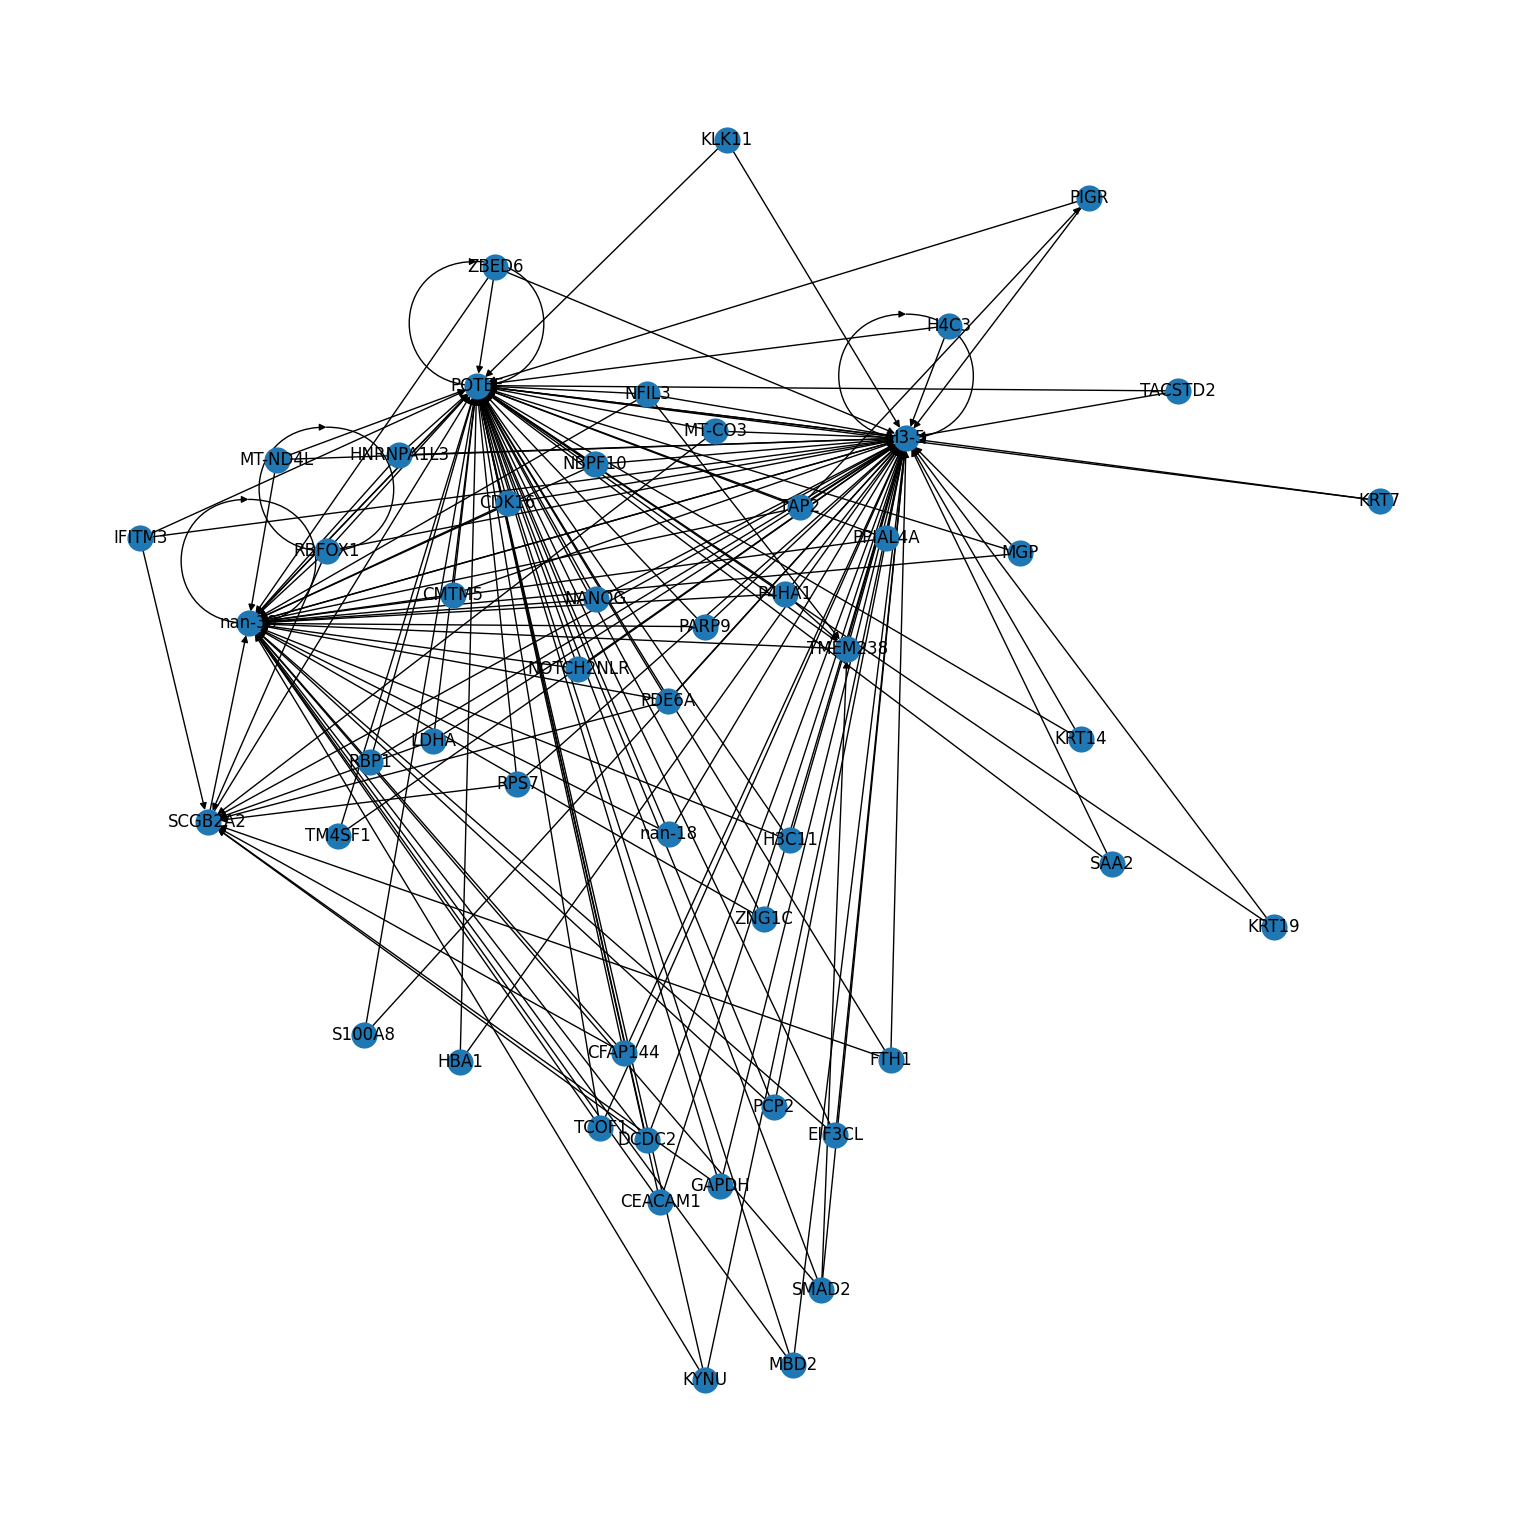

In [35]:
G = grn.plot_subgraph("CEACAM1", max_genes=50, only=150, interactive=False)

In [7]:
pnet

<class 'pyvis.network.Network'> |N|=51 |E|=150

In [31]:
from IPython.display import display, HTML

color2 = "#4D9967"
color3 = "#D1955C"
display(HTML(f'<div style="width:100px;height:100px;background-color:{color3};"></div>'))

In [36]:
pnet = pnx.Network(notebook=True, cdn_resources="remote", directed=True)
# Set one node to color red
pnet.from_nx(G)
first_node = list(G.nodes)[-1]
pnet.get_node(first_node)['color'] = "red"
for i in list(G.nodes)[:-1]:
    pnet.get_node(i)['color'] = color3
pnet.show("temp.html")

temp.html


In [ ]:
grn.varp['GRN'][~grn.var.isTF,:]=0

In [ ]:
BenGRN(grn).scprint_benchmark()

In [ ]:
grn.varp['GRN'] = grn.varp['all'][:,:,:].mean(-1)

In [ ]:
grn.varp['GRN'] = 3*grn.varp['GRN']+grn.varp['GRN'].T
BenGRN(grn).scprint_benchmark()

In [ ]:
metrics = {}
clf_omni = None
for celltype in CELLTYPES:
    grn_inferer = GRNfer(model, adata[adata.X.sum(1) > 500],
                        how="random expr",
                        preprocess="softmax",
                        head_agg='mean',
                        filtration="none",
                        forward_mode="none",
                        num_genes=2200,
                        max_cells=MAXCELLS,
                        doplot=False,
                        batch_size=32,
                        )
    grn = grn_inferer(layer=list(range(model.nlayers))[:], cell_type=celltype)
    grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
    metrics[celltype+'_scprint_full'] = BenGRN(grn).scprint_benchmark()
    del grn
    grn_inferer = GRNfer(model, adata[adata.X.sum(1) > 500],
                        how="most var across",
                        preprocess="softmax",
                        head_agg='none',
                        filtration="none",
                        forward_mode="none",
                        num_genes=NUM_GENES,
                        max_cells=1024,
                        doplot=False,
                        batch_size=16,
                        )
    grn = grn_inferer(layer=list(range(model.nlayers))[:], cell_type=celltype)
    grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
    grn.varp['all'] = grn.varp['GRN']
    grn.varp['GRN'] = grn.varp['GRN'][:,:,:].mean(-1)
    metrics[celltype+'_scprint_mean'] = BenGRN(grn).scprint_benchmark()
    grn.varp['GRN'][~grn.var.isTF,:]=0
    metrics[celltype+'_scprint_tf_mean'] = BenGRN(grn).scprint_benchmark()
    if clf_omni == None:
        grn.varp['GRN'] = grn.varp['all']
        _, m, clf_omni = train_classifier(grn, C=1, train_size=0.6, class_weight={
                                        1: 200, 0: 1}, shuffle=True, max_iter=200, return_full=False)
        joblib.dump(clf_omni, 'clf_omni.pkl')
    grn.varp['GRN'] = grn.varp['all'][:,:,clf_omni.coef_[0] > 0].mean(-1)
    metrics[celltype+'_scprint_class'] = BenGRN(grn).scprint_benchmark()
    grn.varp['GRN'][~grn.var.isTF,:]=0
    metrics[celltype+'_scprint_tf_class'] = BenGRN(grn).scprint_benchmark()
    del grn

In [ ]:
metrics

In [ ]:
import pandas as pd

In [ ]:
res = []
for k, v in metrics.items():
    res.append([k.split('_')[-1], k.split('_')[0], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])

df = pd.DataFrame(res, columns=['tools','name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df